# Transfer Learning with Tensroflow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data

## Downloading and becoming one with the data

In [101]:
# Get data (10% of 10 food classses from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-04-02 12:02:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M  40.3MB/s    in 4.6s    

2023-04-02 12:02:40 (35.2 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [102]:
# How many images in each folder
import os

# Walkt through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 10 directori

## Creating data loaders (preparing the data)

In [103]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
# Setup directories
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [105]:
# Setup data inputs
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         labels="inferred",
                                                         batch_size=32,
                                                         label_mode='categorical',
                                                         image_size=(224, 224),
                                                         shuffle=True,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        labels="inferred",
                                                        label_mode='categorical',
                                                        batch_size=32,
                                                        image_size=(224, 224),
                                                        shuffle=True,
                                                        seed=42)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Setting up callbacks (thing to run whils our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [106]:
# Create TensorBoard callback (functionized because we need to create a new one fort each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir =log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")

  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [107]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"


In [108]:
 # Import dependencies
 import tensorflow as tf
 import tensorflow_hub as hub
 from tensorflow.keras import layers

In [109]:
IMAGE_SHAPE = (224, 224)

In [110]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, n_classes=10):
  """
  Takes a TensorFlow Hub URL and createa a Keras Sequential model with it

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    n_classes (int): Nubmber of output neurons in the output layer
      should be equal to number fo target classes, default 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with n_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create normalization layer
  normalization_layer = tf.keras.Sequential([
      layers.Rescaling(1./255)
  ])

  # Create our own model
  model = tf.keras.Sequential([
      normalization_layer,
      feature_extractor_layer,
      layers.Dense(n_classes, activation="softmax"),
  ])

  return model

### Creating resnet tensorflow hub feature extraction model

In [111]:
# Creeate Resnet model
resnet_model = create_model(model_url=resnet_url, 
                            n_classes=10)

In [112]:
# Compile our resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [113]:
# Create tensorboard callback
tensorboard_callback = create_tensorboard_callback("/content/tensorboard", "resnet_1")

Saving TensorBoard log files to: /content/tensorboard/resnet_1/20230402-120245


In [114]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  steps_per_epoch=len(train_data),
                                  epochs=5,
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[tensorboard_callback])

Epoch 1/5
24/24 [==============================] - 15s 400ms/step - loss: 1.8434 - accuracy: 0.3640 - val_loss: 1.1841 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 10s 419ms/step - loss: 0.8775 - accuracy: 0.7293 - val_loss: 0.8861 - val_accuracy: 0.7168
Epoch 3/5
24/24 [==============================] - 13s 530ms/step - loss: 0.6213 - accuracy: 0.8147 - val_loss: 0.7820 - val_accuracy: 0.7404
Epoch 4/5
24/24 [==============================] - 10s 387ms/step - loss: 0.4689 - accuracy: 0.8653 - val_loss: 0.7058 - val_accuracy: 0.7680
Epoch 5/5
24/24 [==============================] - 10s 421ms/step - loss: 0.3657 - accuracy: 0.9187 - val_loss: 0.6834 - val_accuracy: 0.7740


In [115]:
import matplotlib.pyplot as plt

In [116]:
# Let's create a function to plot loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("Training loss vs validation loss")
  plt.legend()
  plt.xlabel("epochs")

  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("Training accuracy vs validation accuracy")
  plt.legend()
  plt.xlabel("epochs");
    

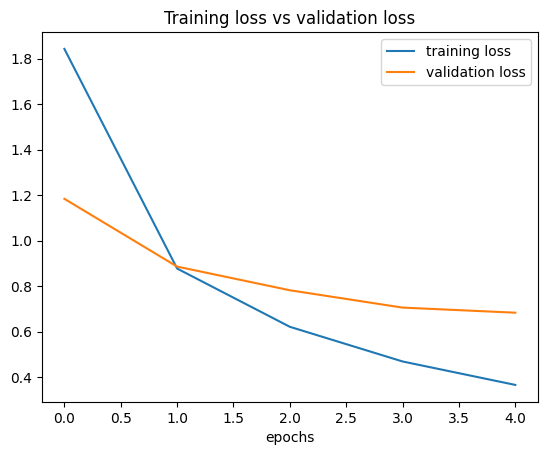

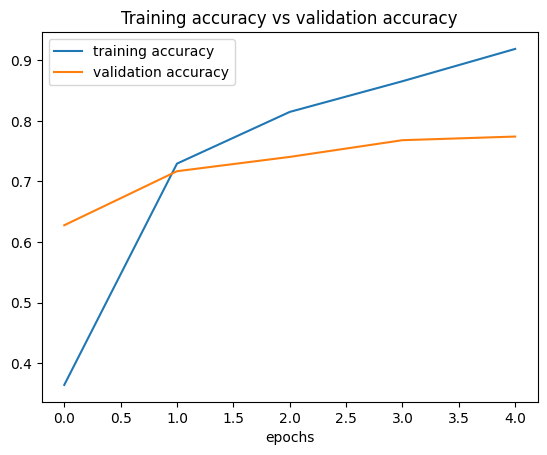

In [117]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction Model

In [118]:
# Create a efficient net model
efficient_net_model = create_model(model_url=efficientnet_url,
                                   n_classes=10)

In [119]:
# Compile efficient net model
efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

In [120]:
# Create tensorboard callback
tensorboard_callback_2 = create_tensorboard_callback("/content/tensorboard", 
                                                     "efficientnet_1")

Saving TensorBoard log files to: /content/tensorboard/efficientnet_1/20230402-120405


In [121]:
# Fit the model
efficient_net_history = efficient_net_model.fit(train_data,
                                                steps_per_epoch=len(train_data),
                                                epochs=5,
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[tensorboard_callback_2])

Epoch 1/5
24/24 [==============================] - 13s 309ms/step - loss: 1.8115 - accuracy: 0.4560 - val_loss: 1.2376 - val_accuracy: 0.7584
Epoch 2/5
24/24 [==============================] - 8s 315ms/step - loss: 1.0256 - accuracy: 0.7853 - val_loss: 0.8352 - val_accuracy: 0.8272
Epoch 3/5
24/24 [==============================] - 9s 351ms/step - loss: 0.7395 - accuracy: 0.8387 - val_loss: 0.6799 - val_accuracy: 0.8508
Epoch 4/5
24/24 [==============================] - 7s 281ms/step - loss: 0.5945 - accuracy: 0.8680 - val_loss: 0.5980 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 8s 345ms/step - loss: 0.5067 - accuracy: 0.8920 - val_loss: 0.5469 - val_accuracy: 0.8648


In [122]:
# Check the model summary
efficient_net_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 dense_7 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


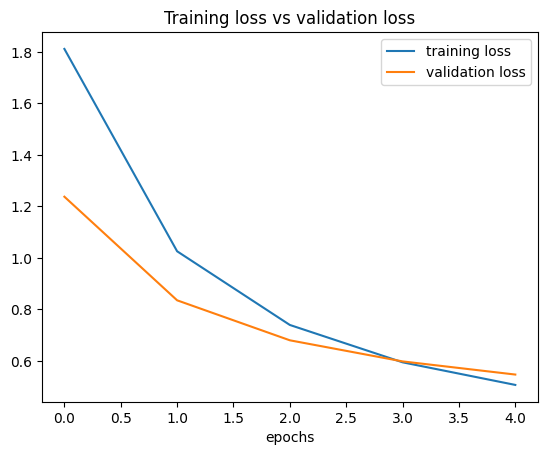

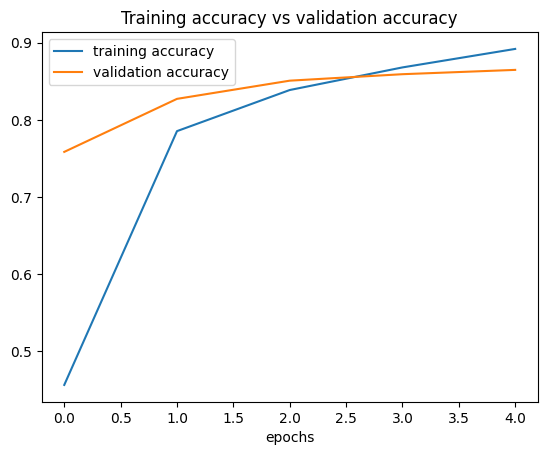

In [123]:
# Plot loss curves
plot_loss_curves(efficient_net_history)

In [124]:
# How many layers does our efficientnetb0 feature extractor have?
efficient_net_model.layers[0]

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g. using ImageNet 
model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** tranfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes => 10 classes of food)
* **"Fine tuning"** tranfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using tensorboard



In [127]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir /content/tensorboard/ \
  --name "EfficientNetB0 vs. ResNet50v2"\
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2023-04-02 12:26:10.611428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ymbJQszARr2rrHNLAmFk9Q/

[2023-04-02T12:26:12] Started scanning logdir.
[2023-04-02T12:26:24] Total uploaded: 270 scalars, 0 tensors, 9 binary objects (14.2 MB)
[2023-04-02T12:26:24] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ymbJQszARr2rrHNLAmFk9Q/


# Exercises

## Exercise 1
Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [128]:
# Setup the mobilenet url
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [129]:
# Create the model
mobilenet_model = create_model(model_url=mobilenet_url,
                               n_classes=10)

# Compile the model
mobilenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# Fit the model
mobilenet_history = mobilenet_model.fit(train_data,
                                        steps_per_epoch=len(train_data),
                                        epochs=5,
                                        validation_data=test_data,
                                        validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 13s 299ms/step - loss: 1.8917 - accuracy: 0.3760 - val_loss: 1.2679 - val_accuracy: 0.6068
Epoch 2/5
24/24 [==============================] - 7s 261ms/step - loss: 0.9972 - accuracy: 0.7200 - val_loss: 0.8749 - val_accuracy: 0.7320
Epoch 3/5
24/24 [==============================] - 8s 307ms/step - loss: 0.7182 - accuracy: 0.8027 - val_loss: 0.7460 - val_accuracy: 0.7688
Epoch 4/5
24/24 [==============================] - 12s 499ms/step - loss: 0.5601 - accuracy: 0.8560 - val_loss: 0.6708 - val_accuracy: 0.7932
Epoch 5/5
24/24 [==============================] - 7s 276ms/step - loss: 0.4608 - accuracy: 0.8907 - val_loss: 0.6426 - val_accuracy: 0.7944


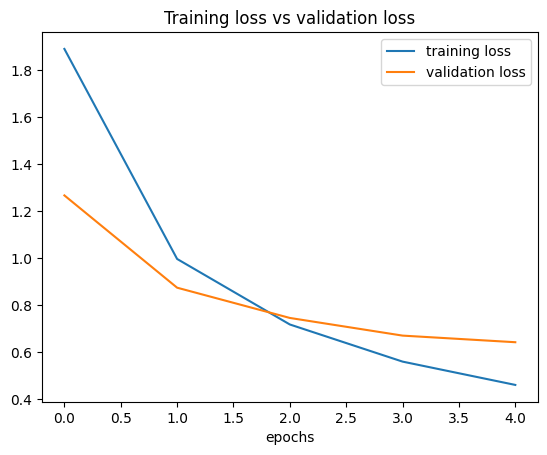

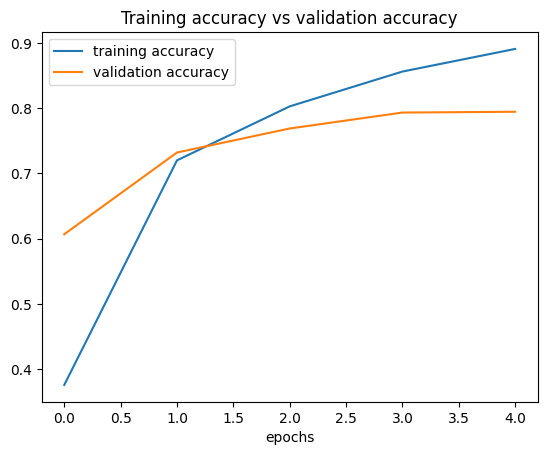

In [130]:
# Plot loss curves
plot_loss_curves(mobilenet_history)